In [1]:
using PyPlot,JLD2,CALCEPH

Using $\sqrt{e} \cos{\omega}$ and $\sqrt{e} \sin{\omega}$ as priors, doesnt work properly. don't know why. Reverted to previous prior $e \cos{\omega}$ and $e \sin{\omega}$

In [187]:
calc_deg(value) = value * 180/pi
calc_rad(value) = value * pi/180
function extract_data(filename)
	f = jldopen(String(filename), "r")
	return f["pbest_global"]
end
function evec(ecc,om)
    omega = calc_rad(om)
    ecosw = ecc*cos(omega)
    esinw = ecc*sin(omega)
    return ecosw,esinw
end

evec (generic function with 1 method)

In [202]:
mu_1,P_1,t01,e1cosw1,e1sinw1,
mu_2,P_2,t02,e2cosw2,e2sinw2,
mu_3,P_3,t03,e3cosw3,e3sinw3,
tmaxsinphi0,tmaxcosphi0,deltaphi = extract_data("OUTPUTS/moon_fittry1params.jld2")

18-element Array{Float64,1}:
    2.5275788989834023e-6
  224.70077098675895     
    2.433503768851615e6  
    0.00285673419852034  
    0.0007550609482464021
    3.04375001408466e-6  
  365.25646214139175     
    2.433624407402546e6  
    0.015037015083073492 
    0.0029763518560029555
    0.000941720902889919 
 4309.232984673987       
    2.443388213396815e6  
    0.02441377873531106  
   -0.03777031122605469  
    9.295524225689489e-5 
   -0.0016399728262300934
    2.312317961379825    

In [203]:
@load("NYR40/moon_try1mcmc.jld2")

8-element Array{Symbol,1}:
 :par_mcmc    
 :lprob_mcmc  
 :param       
 :nwalkers    
 :nsteps      
 :accept      
 :iburn       
 :indepsamples

In [11]:
include("decompose_ttvs.jl")
include("plot_ttvs.jl")
include("plot_likelihood.jl")
include("corner_plot.jl")

corner_planet (generic function with 1 method)

In [193]:
evec(0.00677323,131.53298)

(-0.004490997226230397, 0.005070265135758768)

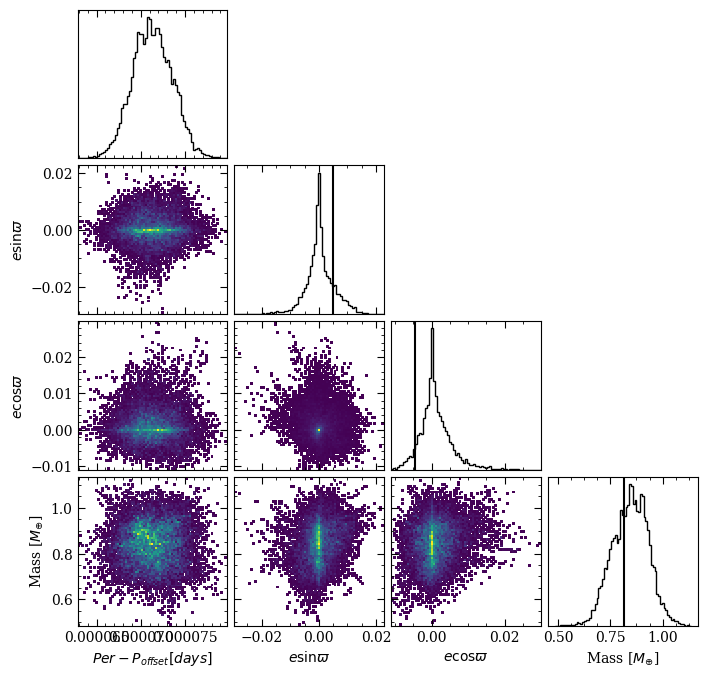

In [213]:
corner_planet(vec(par_mcmc[1:10,iburn:nsteps,1]).* CGS.MSUN/CGS.MEARTH,
    (vec(par_mcmc[1:10,iburn:nsteps,4]).*sqrt.(vec(par_mcmc[1:10,iburn:nsteps,4]).^2 .+ vec(par_mcmc[1:10,iburn:nsteps,5]).^2)),
    (vec(par_mcmc[1:10,iburn:nsteps,5]).*sqrt.(vec(par_mcmc[1:10,iburn:nsteps,4]).^2 .+ vec(par_mcmc[1:10,iburn:nsteps,5]).^2)),
    vec(par_mcmc[1:10,iburn:nsteps,2]),75,
0.815,-0.0044,0.0051,224.7007992,"venus")

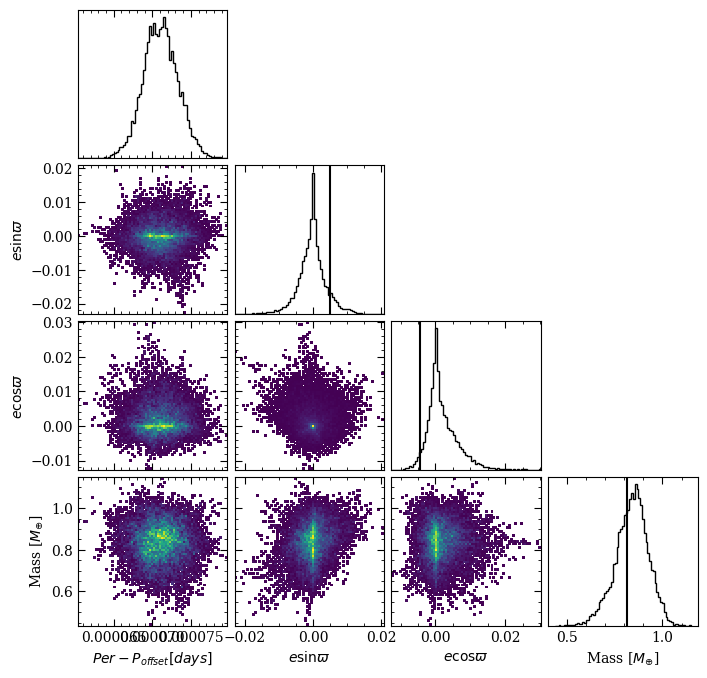

In [214]:
corner_planet(vec(par_mcmc[11:20,iburn:nsteps,1]).* CGS.MSUN/CGS.MEARTH,
    (vec(par_mcmc[11:20,iburn:nsteps,4]).*sqrt.(vec(par_mcmc[11:20,iburn:nsteps,4]).^2 .+ vec(par_mcmc[11:20,iburn:nsteps,5]).^2)),
    (vec(par_mcmc[11:20,iburn:nsteps,5]).*sqrt.(vec(par_mcmc[11:20,iburn:nsteps,4]).^2 .+ vec(par_mcmc[11:20,iburn:nsteps,5]).^2)),
    vec(par_mcmc[11:20,iburn:nsteps,2]),75,
0.815,-0.0044,0.0051,224.7007992,"venus")

In [ ]:
corner_planet(vec(par_mcmc[1:10,iburn:nsteps,1]).* CGS.MSUN/CGS.MEARTH,
    (vec(par_mcmc[1:10,iburn:nsteps,4]).*sqrt.(vec(par_mcmc[1:10,iburn:nsteps,4]).^2 .+ vec(par_mcmc[1:10,iburn:nsteps,5]).^2)),
    (vec(par_mcmc[1:10,iburn:nsteps,5]).*sqrt.(vec(par_mcmc[1:10,iburn:nsteps,4]).^2 .+ vec(par_mcmc[1:10,iburn:nsteps,5]).^2)),
    vec(par_mcmc[1:10,iburn:nsteps,2]),75,
0.815,-0.0044,0.0051,224.7007992,"venus")

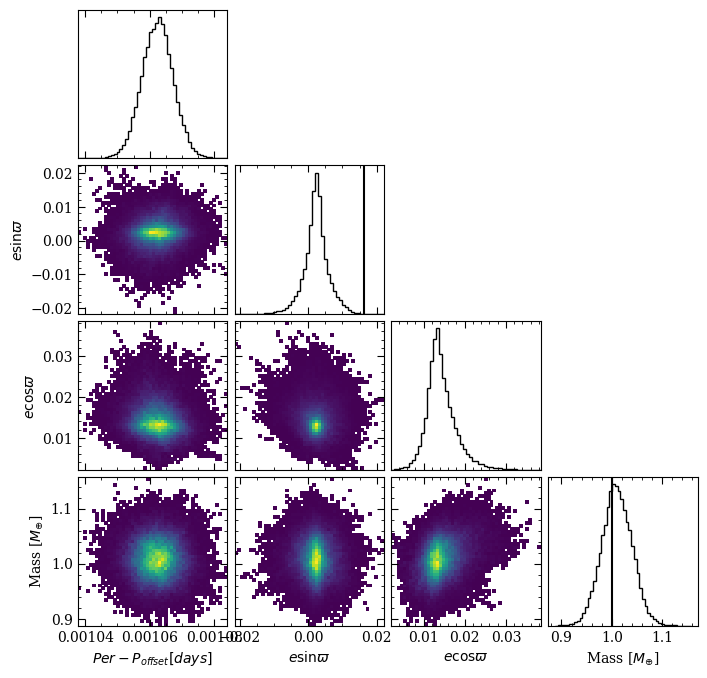

In [207]:
corner_planet(vec(par_mcmc[:,1:nsteps,6]).* CGS.MSUN/CGS.MEARTH,
    (vec(par_mcmc[:,1:nsteps,9]).*sqrt.(vec(par_mcmc[:,1:nsteps,9]).^2 .+ vec(par_mcmc[:,1:nsteps,10]).^2)),
    (vec(par_mcmc[:,1:nsteps,10]).*sqrt.(vec(par_mcmc[:,1:nsteps,9]).^2 .+ vec(par_mcmc[:,1:nsteps,10]).^2)),
    vec(par_mcmc[:,1:nsteps,7]),50,
1,-0.00374,0.016285,365.2564,"earth")

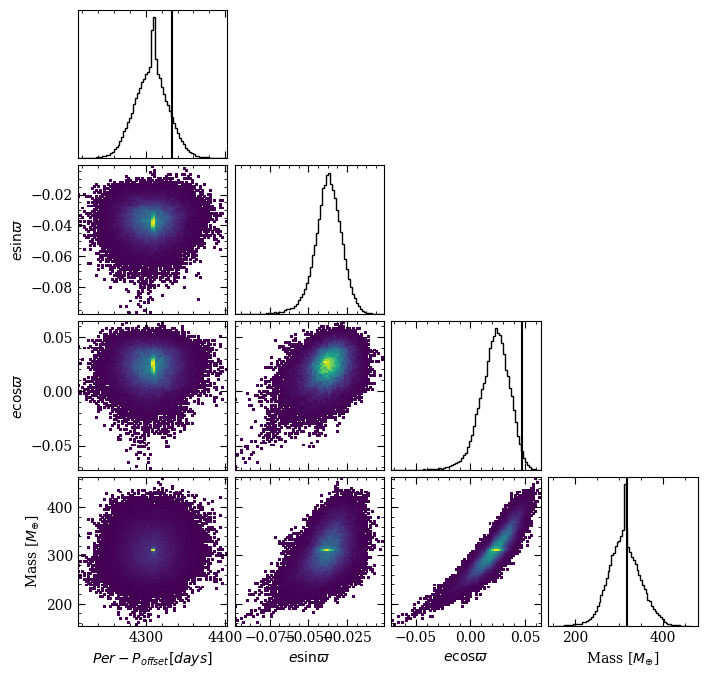

In [206]:
corner_planet(vec(par_mcmc[:,1:nsteps,11]).* CGS.MSUN/CGS.MEARTH,
     (vec(par_mcmc[:,1:nsteps,14]).*sqrt.(vec(par_mcmc[:,1:nsteps,14]).^2 .+ vec(par_mcmc[:,1:nsteps,15]).^2)),
   (vec(par_mcmc[:,1:nsteps,15]).*sqrt.(vec(par_mcmc[:,1:nsteps,14]).^2 .+ vec(par_mcmc[:,1:nsteps,15]).^2)),
    vec(par_mcmc[:,1:nsteps,12]),75,
318,0.0468,0.0123,4332.82012875,"jup")

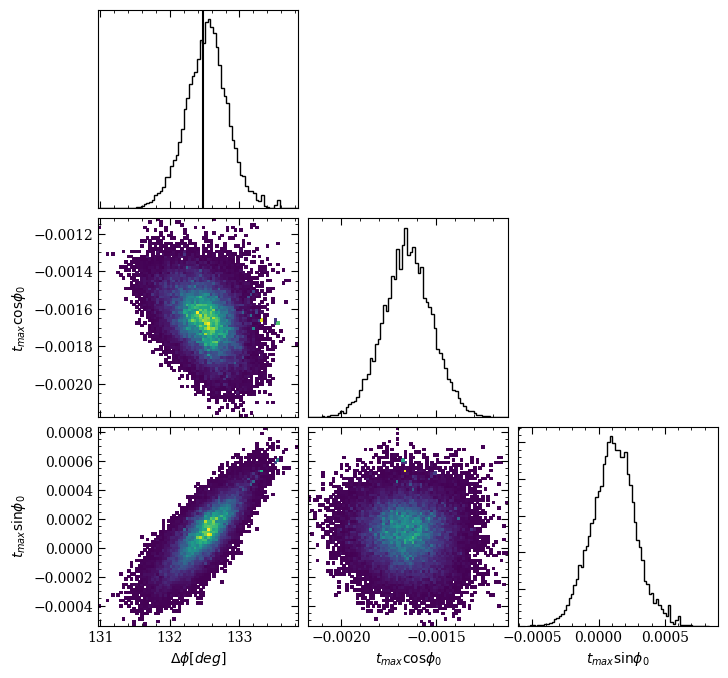

In [174]:
corner_moon(vec(par_mcmc[:,iburn:nsteps,16]),
    vec(par_mcmc[:,iburn:nsteps,17]),
    vec(par_mcmc[:,iburn:nsteps,18]).*57.2957795,75,
 0.00001,0.00001,2.3122.*57.2957795,"moon")

Using original prior on eccentricity.

In [183]:
mu_1,P_1,t01,e1cosw1,e1sinw1,
mu_2,P_2,t02,e2cosw2,e2sinw2,
mu_3,P_3,t03,e3cosw3,e3sinw3,
tmaxsinphi0,tmaxcosphi0,deltaphi = extract_data("OUTPUTS/moon_fitmtry3params.jld2")
@load("mcmc_mtry3results.jld2")

8-element Array{Symbol,1}:
 :par_mcmc    
 :lprob_mcmc  
 :param       
 :nwalkers    
 :nsteps      
 :accept      
 :iburn       
 :indepsamples

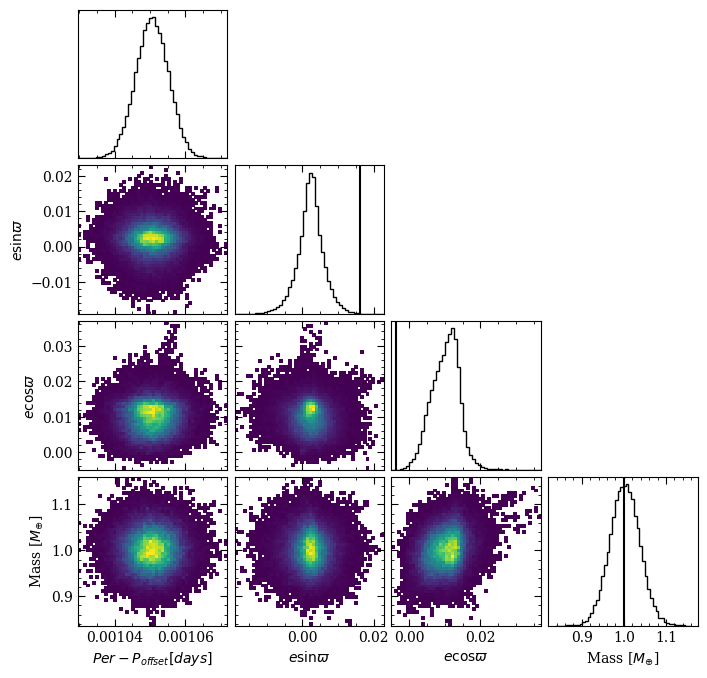

In [190]:
corner_planet(vec(par_mcmc[:,iburn:nsteps,6]).* CGS.MSUN/CGS.MEARTH,
    vec(par_mcmc[:,iburn:nsteps,9]),
    vec(par_mcmc[:,iburn:nsteps,10]),
    vec(par_mcmc[:,iburn:nsteps,7]),50,
1,-0.00374,0.016285,365.2564,"earth")

In [2]:
f = jldopen("FITS/p3_fit30.0s40.0yrs.jld2","r")
g = jldopen("FITS/moon_fit30.0s40.0yrs.jld2","r")

JLDFile /Users/bethleelindor/work/washington/ttv_project/ttv_ss/FITS/moon_fit30.0s40.0yrs.jld2 (read-only)
 ├─🔢 pbest_p3
 ├─🔢 pbest_dp
 ├─🔢 lprob_p3
 ├─🔢 lprob_dp
 ├─🔢 lprob_best
 ├─🔢 pbest_global
 ├─🔢 ntrans
 ├─🔢 nplanet
 ├─🔢 tt0
 ├─🔢 tt
 ├─🔢 ttmodel
 ├─🔢 sigtt
 ├─🔢 p3in
 ├─🔢 p3out
 ├─🔢 np3
 ├─🔢 nphase
 ├─🔢 dpin
 ├─🔢 dpout
 └─🔢 ndp

In [46]:
mcmc = jldopen("MCMC/p3_mcmc30.0s40.0yrs.jld2")
moon = jldopen("MCMC/moon_mcmc30.0s40.0yrs.jld2")

JLDFile /Users/bethleelindor/work/washington/ttv_project/ttv_ss/MCMC/moon_mcmc30.0s40.0yrs.jld2 (read-only)
 ├─🔢 par_mcmc
 ├─🔢 lprob_mcmc
 ├─🔢 param
 ├─🔢 nwalkers
 ├─🔢 nsteps
 ├─🔢 accept
 ├─🔢 iburn
 └─🔢 indepsamples

In [62]:
wide = jldopen("FITS/p3_widefit30.0s40.0yrs.jld2","r")
grid_wide = (10 .^ range(log10(wide["p3in"]),stop=log10(wide["p3out"]),length=wide["np3"])) /365.25
lprob_wide = exp.((wide["lprob_p3"] .-maximum(wide["lprob_p3"])))

xgrid = (10 .^ range(log10(f["p3in"]),stop=log10(f["p3out"]),length=f["np3"])) /365.25
xprob = exp.((f["lprob_p3"] .-maximum(f["lprob_p3"])))

100-element Array{Float64,1}:
 2.0565136362713246e-5 
 3.0338010875769516e-5 
 4.45395037921047e-5   
 6.506327101592419e-5  
 9.455719138740711e-5  
 0.00013669670632574413
 0.00019654114919993724
 0.00028100987951051155
 0.00039947479360921006
 0.0005645385453117475 
 0.0007929921051064429 
 0.001107007575204465  
 0.0015355706983556292 
 ⋮                     
 0.0011731437990394437 
 0.0008431833596150389 
 0.0006023714296079696 
 0.0004278071372535105 
 0.0003020952817830991 
 0.00021213701232188884
 0.0001481639747368943 
 0.00010294012384364075
 7.115643647834202e-5  
 4.894427991790503e-5  
 3.350549161632392e-5  
 2.2831186845949376e-5 

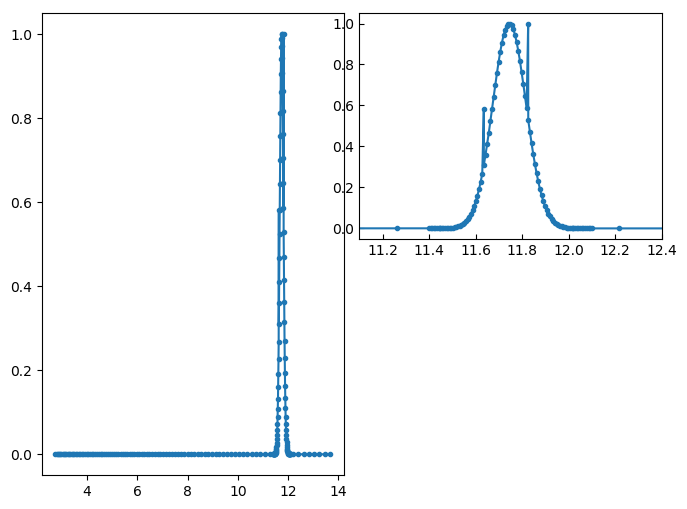

In [309]:
M = [xgrid xprob ;grid_wide lprob_wide]
sorted = sortperm(M[:,1])
fig = plt.figure(figsize=(8,6))
subplots_adjust(hspace=0.05,wspace=0.05)
ax1=fig.add_subplot(121)
plot(M[:,1][sorted],M[:,2][sorted],".",linestyle="-")
# ax1.tick_params(direction="in",left=false,labelleft=false,right=true,labelright=true)
ax2=fig.add_subplot(222)
plot(M[:,1][sorted],M[:,2][sorted],".",linestyle="-")
xlim(11.1,12.4)
ax2.tick_params(direction="in")

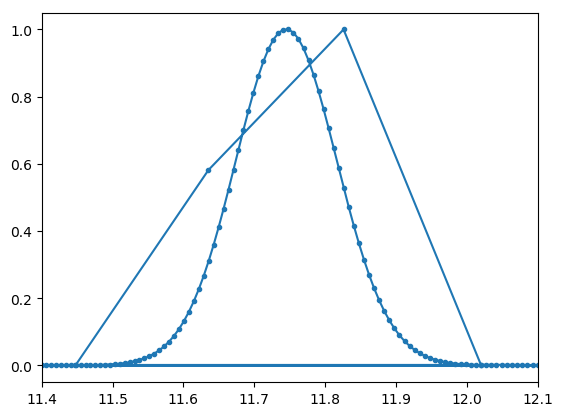

(11.4, 12.1)

In [146]:
# allgrid = vcat(grid_wide,xgrid)
# allprob = vcat(lprob_wide,xprob)
# sorted = sortperm(allgrid)
plot(M[:,1][sorted],M[:,2][sorted],".",linestyle="-")
xlim(11.4,12.1)

In [68]:
allgrid.sorted()

ErrorException: type Array has no field sorted

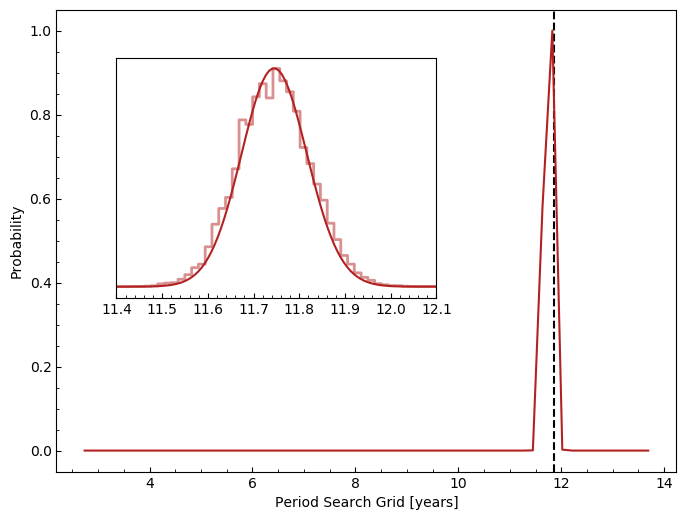

In [246]:
include("plot_likelihood.jl")
plot_likelihood(f,mcmc,false)

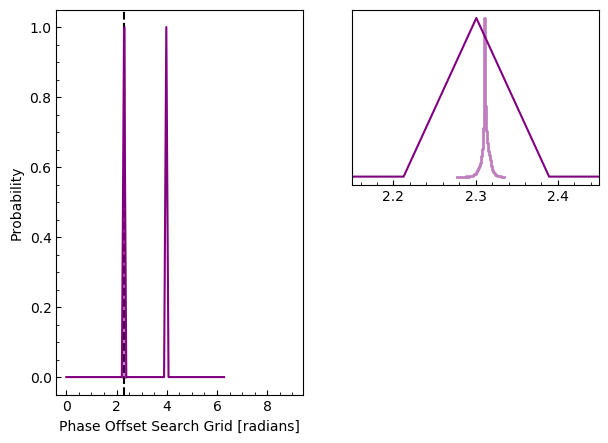

In [300]:
include("plot_likelihood.jl")
plot_likelihood(g,moon,true)

jupiter period agreement --> unique solution & not degenerate

In [44]:
using Distributions,Optim

Q: when we talk about goodness of fit, we're comparing the "best" fit to the true value (or another model, if available) but we can only characterize the best fit value by the MCMC sampling, correct? So when showing the likelihoods, which value is preferred?

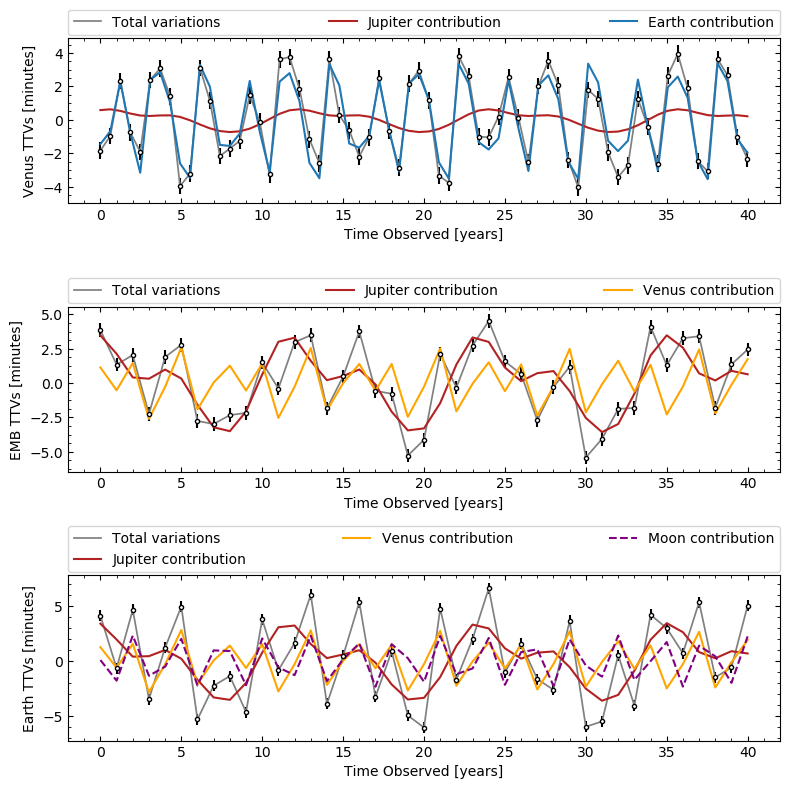

In [43]:
include("plot_ttvs.jl")
plot_ttvs(f,true)
# savefig("IMAGES/EMBttvs.eps")

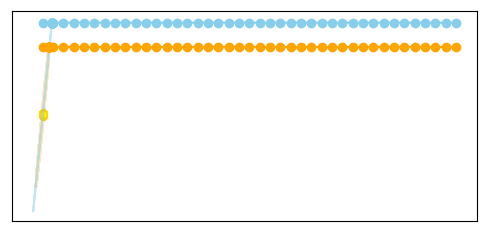

In [183]:
include("plot_orbits.jl")
plot_orbits(2,false)

In [157]:
mean(mcmc["par_mcmc"][:,mcmc["iburn"]:end,12])/365.25

11.744669306512693

In [165]:
mean(moon["par_mcmc"][:,moon["iburn"]:end,18])/pi

0.7358218362888413

In [180]:
8pi/12

2.0943951023931953

In [221]:
400/365.25

1.0951403148528405

In [220]:
1.5 * 365.25

547.875